# DSPM Project:
### Group Member: Xi Yan, Tiffany Huang, Wanying Zhang


## Part 0: Data Preprocessing

Import packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import re #regular expressions
import spacy #natural language processing import pandas as pd
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.stem import WordNetLemmatizer
from collections import Counter
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Mount drive

Read files

In [ ]:
df = pd.read_excel('Diabetes Continuous Glucose Monitoring – Data Export.xlsx')
df.head()

Post ID                                    Sound Bite Text  \
0   BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   
1   BRDRDT2-t1_impbcf4  I tried it for a little while. No side effects...   
2  1565738759353602048  i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3    17944607459251789  MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4   BRDRDT2-t1_imq8h9m  This is also because like a soak in a hot tub ...   

   Ratings and Scores                                              Title  \
0                 NaN  Have you been denied a second/third pump? Feel...   
1                 NaN                                          Metformin   
2                 NaN                                                NaN   
3                 NaN                                                NaN   
4                 NaN                   No bath salts, bath oils, soaks?   

  Source Type             Post Type Is Paid Media Type  \
0      Forums  Replies and Comments      No   No Media   
1      Forums  Replies and Comments      No   No Media   
2     Twitter  Replies and Comments      No       Link   
3   Instagram              Original      No      Image   
4      Forums  Replies and Comments      No   No Media   

                                                 URL  \
0  https://www.reddit.com/r/diabetes_t1/comments/...   
1  https://www.reddit.com/r/diabetes_t1/comments/...   
2  http://twitter.com/bromid/statuses/15657387593...   
3           https://www.instagram.com/p/Ch-gqL-Onqk/   
4  https://www.reddit.com/r/diabetes/comments/x3e...   

                                          Media Link  ...  \
0                                                NaN  ...   
1                                                NaN  ...   
2                                                NaN  ...   
3  https://scontent-iad3-1.cdninstagram.com/v/t51...  ...   
4                                                NaN  ...   

  LexisNexis Company - Any LexisNexis Person - High LexisNexis Person - Any  \
0                      NaN                      NaN                     NaN   
1                      NaN                      NaN                     NaN   
2                      NaN                      NaN                     NaN   
3                      NaN                      NaN                     NaN   
4                      NaN                      NaN                     NaN   

  LexisNexis Institution - High LexisNexis Institution - Any  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   

  LexisNexis Subject Group 1 LexisNexis Subject 1 LexisNexis Subject Group 2  \
0                        NaN                  NaN                        NaN   
1                        NaN                  NaN                        NaN   
2                        NaN                  NaN                        NaN   
3                        NaN                  NaN                        NaN   
4                        NaN                  NaN                        NaN   

  LexisNexis Subject 2 LexisNexis Other Subjects  
0                  NaN                       NaN  
1                  NaN                       NaN  
2                  NaN                       NaN  
3                  NaN                       NaN  
4                  NaN                       NaN  

[5 rows x 63 columns]

Check the percentage of missing values in each column

In [ ]:
percent_missing = round(df.isnull().sum() * 100 / len(df),2)
missing_value_df = pd.DataFrame({'percent_missing %': percent_missing})
missing_value_df

percent_missing %
Post ID                                  0.00
Sound Bite Text                          0.00
Ratings and Scores                     100.00
Title                                    4.15
Source Type                              0.00
...                                       ...
LexisNexis Subject Group 1             100.00
LexisNexis Subject 1                   100.00
LexisNexis Subject Group 2             100.00
LexisNexis Subject 2                   100.00
LexisNexis Other Subjects              100.00

[63 rows x 1 columns]

Delete columns containing either 90% or more than 90% NaN Values

In [ ]:
perc = 90.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df1 = df.dropna(axis=1,thresh=min_count)

Check the percentage of missing values in each column

In [ ]:
percent_missing = round(df1.isnull().sum() * 100 / len(df1),2)
missing_value_df = pd.DataFrame({'percent_missing %': percent_missing})
missing_value_df

percent_missing %
Post ID                                                   0.00
Sound Bite Text                                           0.00
Title                                                     4.15
Source Type                                               0.00
Post Type                                                 7.08
Is Paid                                                   0.00
Media Type                                                0.00
URL                                                       0.00
Domain                                                    0.00
Sentiment                                                 0.00
Published Date (GMT-04:00) New York                       0.00
Author Gender                                             0.00
Author URL                                                6.65
Author Name                                               2.52
Author Reddit Karma                                       0.00
Followers/Daily Unique Visitors/Subscribers              18.56
Positive Objects                                         76.73
Negative Objects                                         87.98
Richness                                                  0.00
Reddit Score                                              0.00
Source Name                                              10.98

Since "Positive Objects" and "Negative Objects" have over 75% of missing values, we decided to drop these two columns

In [ ]:
df1 = df1.drop(['Positive Objects','Negative Objects'], axis=1)

Now we have finished cleaning empty columns, we starts to process the text.

## Part 1: Text processing

In [ ]:
df1.head(1)

Post ID                                    Sound Bite Text  \
0  BRDRDT2-t1_imq98sr  My numbers are great now. Estimated a1c of 7%i...   

                                               Title Source Type  \
0  Have you been denied a second/third pump? Feel...      Forums   

              Post Type Is Paid Media Type  \
0  Replies and Comments      No   No Media   

                                                 URL      Domain Sentiment  \
0  https://www.reddit.com/r/diabetes_t1/comments/...  reddit.com  Neutrals   

  Published Date (GMT-04:00) New York Author Gender  \
0              Sep 1, 2022 7:41:36 PM       Unknown   

                                         Author URL           Author Name  \
0  https://www.reddit.com/user/itsgucciflipflopsbro  itsgucciflipflopsbro   

  Author Reddit Karma  Followers/Daily Unique Visitors/Subscribers  Richness  \
0                4472                                      42768.0         0   

  Reddit Score    Source Name  
0            0  r/diabetes_t1

Since the column "Sound Bite Text" and "Title" have the important text content, we decide to merge them at the beginning

The "Title" column also have empty cell, we need to fill the empty column before merging

In [ ]:
df1['Title'].fillna(value = 'Empty_Title', inplace = True)

Now merge

In [ ]:
df1['Sound Bite Text'] = df1['Sound Bite Text'] + " " + df1['Title']

Now we process the text:

The text processing steps are:
1. Remove links (characters that include www)
2. Remove punctuations
3. Remove emojis

After these 3 basic steps, we then:
4. Tokenize text
5. Remove Stopwords
6. Lemmatization

We think that these 6 steps can let the text data contain most of the useful information and eliminate the meaningless information

In [ ]:
df2 = df1.copy()

Remove links

In [ ]:
df2["no links"] = df2["Sound Bite Text"].apply(lambda s: ' '.join(re.sub("(w+://S+)", " ", s).split()))

Remove punctuations

In [ ]:
def remove_punctuation(test_str):
# Using filter() and lambda function to filter out punctuation characters
  result = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), test_str))
  return result

In [ ]:
df2["no punc"] = df2["no links"].apply(lambda s: remove_punctuation(s))

Remove emojis

In [ ]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [ ]:
df2["clean_text"] = df2["no punc"].apply(lambda s: deEmojify(s))

Tokenize text

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')  # load spaCy's built-in English models
from nltk.tokenize import WhitespaceTokenizer

In [ ]:
texts = df2['clean_text'].to_numpy()
tokens = []

# Create a reference variable for Class WhitespaceTokenizer
tk = WhitespaceTokenizer()

for txt in texts:
    token = [word for word in tk.tokenize(txt.lower()) if word not in nlp.Defaults.stop_words]
    tokens.append(token)

In [ ]:
df2["tokens"] = tokens

Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def text_lemmatize(text, position):
    lemmatizer = WordNetLemmatizer()
    words_lemmatize = []
    for i in text:
        words_lemmatize.append(WordNetLemmatizer().lemmatize(i, pos= position))
    #text_lemmatize = " ".join(words_lemmatize)
    return words_lemmatize

In [ ]:
# Lemmatize verbs
lemma_v = []
for i in range(0, len(df2)):
    lemma_v.append(text_lemmatize(df2["tokens"][i], "v"))
df2["lemma_v"] = lemma_v

# Lemmatize nouns
lemma_n = []
for i in range(0, len(df2)):
    lemma_n.append(text_lemmatize(df2["lemma_v"][i], "n"))
df2["lemma_n"] = lemma_n

# Lemmatize adjectives
lemma_clean = []
for i in range(0, len(df2)):
    lemma_clean.append(text_lemmatize(df2["lemma_n"][i], "a"))
df2["lemma_clean"] = lemma_clean

Remove the list bracket and comma in the "lemma_clean" column

In [ ]:
def clean_text(text):
    # Convert list to string
    text_str = ' '.join(text)
    # Remove non-alphanumeric characters except for spaces
    text_str = re.sub(r'[^a-zA-Z0-9\s]+', '', text_str)
    # Remove extra spaces
    text_str = re.sub(r'\s+', ' ', text_str)
    # Strip leading/trailing spaces
    text_str = text_str.strip()
    return text_str
  
df2['text_clean'] = df2['lemma_clean'].apply(clean_text)

In [ ]:
df2[["Sound Bite Text", "lemma_clean", "text_clean"]]

Sound Bite Text  \
0      My numbers are great now. Estimated a1c of 7%i...   
1      I tried it for a little while. No side effects...   
2      i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3      MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4      This is also because like a soak in a hot tub ...   
...                                                  ...   
37839  Push for it, it's a game changer in my opinion...   
37840  (My mom learned to inject my 10 year old self ...   
37841  I just spoke with a rep from Abbott. The rep t...   
37842  It’s been 2.5 weeks since I started and I’m fe...   
37843  My first endo told me, paraphrasing, 'If you d...   

                                             lemma_clean  \
0      [number, great, estimate, a1c, 7ish, doesnt, c...   
1      [try, little, effect, help, insulin, resistanc...   
2      [run, character, youtuberwgl2pdhqim, ill, newl...   
3      [lunch, eat, 1030am, 1, unit, novolog, insulin...   
4      [like, soak, hot, tub, potential, exist, low, ...   
...                                                  ...   
37839  [push, game, changer, opinion, course, come, i...   
37840  [mom, learn, inject, 10, year, old, self, oran...   
37841  [speak, rep, abbott, rep, tell, plan, update, ...   
37842  [25, week, start, im, feel, good, literal, yea...   
37843  [endo, tell, paraphrase, exactly, right, youll...   

                                              text_clean  
0      number great estimate a1c 7ish doesnt care wan...  
1      try little effect help insulin resistance find...  
2      run character youtuberwgl2pdhqim ill newly dia...  
3      lunch eat 1030am 1 unit novolog insulin pump g...  
4      like soak hot tub potential exist low blood su...  
...                                                  ...  
37839  push game changer opinion course come issue li...  
37840  mom learn inject 10 year old self orange nurse...  
37841  speak rep abbott rep tell plan update freestyl...  
37842  25 week start im feel good literal year skin l...  
37843  endo tell paraphrase exactly right youll range...  

[37844 rows x 3 columns]

Create a new dataframe which contains all useful columns for next steps

In [ ]:
df3 = df2.copy()
df3 = df3[["Sound Bite Text", "Title", "Source Type", "Post Type", "Is Paid", "Media Type", "Domain",
 "Sentiment", "Author Gender", "lemma_clean", "text_clean"]]

## Part 2 Exploratory data analysis 

<AxesSubplot:xlabel='Source Type'>

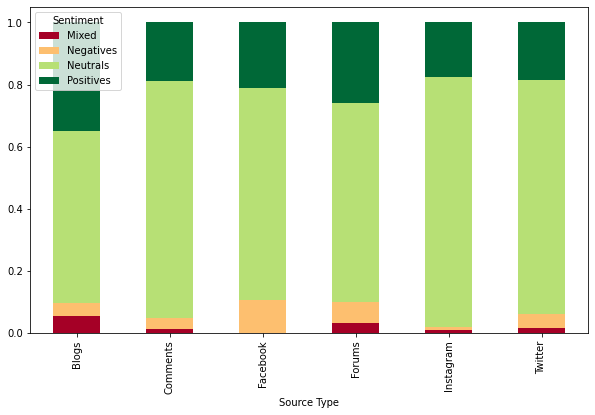

In [ ]:
cross_sentiments_source = pd.crosstab(index=df2['Source Type'],
                             columns=df2['Sentiment'],
                             normalize="index")
cross_sentiments_source.plot(kind='bar', 
                    stacked=True, 
                    colormap='RdYlGn', 
                    figsize=(10, 6))


## Part 2: General CGM analysis


In [ ]:
df_p2 = df3.copy()

### a1. What are patient expectations of CGMs? 

To approch this question, we think we need to extract the rows from the dataset which contain some keywords that represent the "expectation" from the general dataset, then we can run Topic modeling to hopefully get insights from it.

We then summarized the keyword list that we think it represent the sense of "expectation"

In [ ]:
expectation_list = ['expect', 'want', 'need','look', 'forward', 'require', 
                    'anticipate', 'desire', 'prefer', 'hope', 'wish', 
                    'envision', 'imagine', 'plan', 'consider', 'suggest']

Then, we extract the rows that contains words that match any one of the expectation list

In [ ]:
expectation_df = df_p2[df_p2['lemma_clean'].apply(lambda x: any(item for item in x if item in expectation_list))]
expectation_df.shape

(14643, 11)

Turns out there are 14643, about 38 percent of all the text

Then, tag all of the words in the expectation dataframe into noun, verb, and adjectives

In [ ]:
adjs = []
nouns = []
verbs = []

for i in expectation_df['text_clean']:
    for token in nlp(i):
        if token.pos_ == 'ADJ':
            adjs.append(token.text)
        elif token.pos_ == 'NOUN':
            nouns.append(token.text)
        elif token.pos_ == 'VERB':
            verbs.append(token.text)

We count how many occurences for each of the words in each category

In [ ]:
adjs_count = Counter(adjs)
nouns_count = Counter(nouns)
verbs_count = Counter(verbs) 

We want to visualize them in word clouds to see what we can find

In [ ]:
from wordcloud import WordCloud, STOPWORDS

Word cloud for nouns

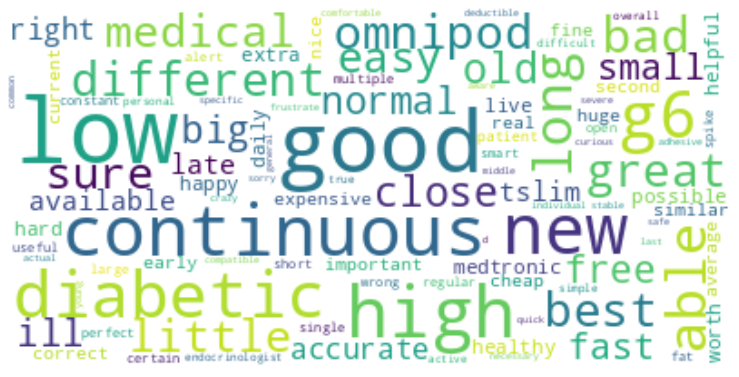

In [ ]:
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(adjs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

Word cloud for verbs

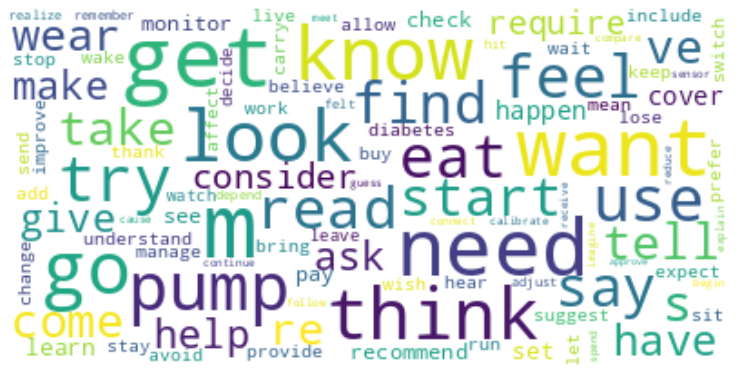

In [ ]:
wc_v = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(verbs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_v, interpolation="bilinear")
plt.axis('off')
plt.show()

Word cloud for nouns

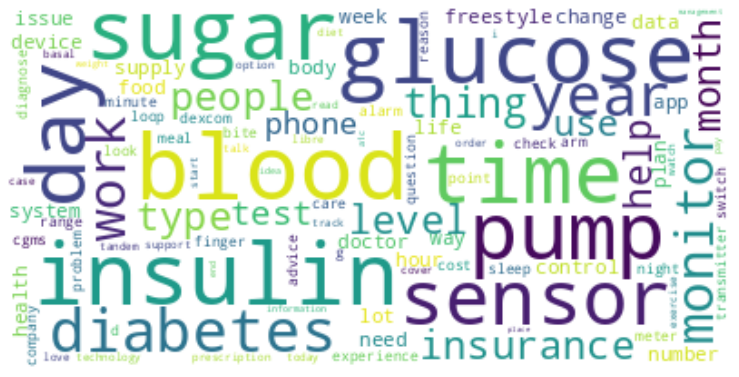

In [ ]:
wc_n = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(nouns_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_n, interpolation="bilinear")
plt.axis('off')
plt.show()

Insights: **nothing!** 

After the previous step, we find out that this is a bad idea since
1. There are too many words that it is for sure it would be there, such as (good, blood, sugar, diabetes)
2. 1 word, even though from each class, does not contain any meaning! For example, what does "insurance" mean in this patients' expectation? Does it mean insurance cost too high? Does it mean insurance is covered/not covered? We just simply cannot tell from this wordcloud analysis.

Therefore, we decided to find another way to look for the answer - which we try to cluster these words into most commom series of words (trigrams, etc.)

We find that tf vectorizer can do the function of outputing the trigrams or whatever how many grams we want in a clause

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
STOPWORDS = []
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=STOPWORDS, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(expectation_df['text_clean'])

In [ ]:
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('continuous glucose monitor', 2245),
 ('blood sugar level', 442),
 ('glucose monitor cgm', 410),
 ('low blood sugar', 290),
 ('check blood sugar', 267),
 ('freestyle libre sensor', 230),
 ('blood glucose level', 219),
 ('close loop system', 196),
 ('cgm continuous glucose', 183),
 ('insulin pump cgm', 162),
 ('use freestyle libre', 160),
 ('high blood sugar', 158),
 ('monitor blood sugar', 155),
 ('glucose monitor system', 135),
 ('use dexcom g6', 130),
 ('dexcom g6 cgm', 123),
 ('test blood sugar', 117),
 ('wear continuous glucose', 115),
 ('dexcom g6 sensor', 114),
 ('glucose monitor device', 113),
 ('libre 14 day', 113),
 ('blood glucose meter', 104),
 ('tandem tslim x2', 102),
 ('blood glucose monitor', 98),
 ('cgm insulin pump', 94)]

Now these trigrams are getting close to what we wants, but it has a lot of repetitive words or words we do not want(stopwords), we need to clear them out.

In [ ]:
expectation_stop = ['freestyle', 'dexcom', 'blood', 'sugar', 'insulin', 'pump',
                    'diabetes', 'continuous', 'glucose', 'libre', 'x2', 'g6', 
                    'medtronic', '770g', 'rdiabetes', 'tslim', 'cgm', 'brooklyn',
                    'thread', 'bronx', 'im'] + expectation_list

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=expectation_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(expectation_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('close loop system', 203),
 ('durable medical equipment', 57),
 ('hybrid close loop', 55),
 ('14 day sensor', 51),
 ('low carb diet', 50),
 ('multiple daily injection', 50),
 ('insurance doesnt cover', 44),
 ('tandem control iq', 44),
 ('apple watch series', 42),
 ('insurance wont cover', 42),
 ('multiple time day', 35),
 ('check time day', 34),
 ('start new sensor', 34),
 ('test time day', 34),
 ('dont nondiabetics cgms', 30),
 ('finger prick test', 29),
 ('prick finger time', 29),
 ('wake middle night', 29),
 ('90 day supply', 28),
 ('flash monitor system', 28),
 ('go high low', 28),
 ('improve quality life', 28),
 ('last 10 day', 28),
 ('10 year old', 27),
 ('24 hour day', 27)]

### a1 answer:

From these most common trigrams filtered from keywords that express "expectation", we can actually tell many things people are expecting on general cgm:
1. "Close loop system" - something that FDA did not pass back then but patients want it to pass
2. "Durable medical equipment" - patients want the CGM to be listed as Durable Medical Equipment by the health supplier, where they can save more money in this way by letting health insurance to cover the cost.
3. "insurance doesnt cover" - maybe people want the equiments to be covered by medical insurance
4. "apple watch series" - people might want apple watch to perform the same function as cgm equipments
5. "improve quality life" - people expect cgm to improve the quality of their lives

### a2. What are patient knowledge gaps with CGMs?

We summarized the keyword list that we think it represent the sense of "confusion", which shows that they have knowledge gaps

In [ ]:
confuse_list = ['confuse', 'unclear', 'misunderstand', 'misconception', 
                'unsure', 'clarification', 'inexperienced', 'inexperience',
                'unfamiliar', 'complex', 'difficult', 'challange', 'challanging',
                'lack', 'hard', 'gap', 'trouble', 'uncertain', 'hard',
                'question', 'ask', 'trick', 'concern', 'complication', 'nightmare']

Extract rows containing the keywords that express confusion

In [ ]:
confuse_df = df_p2[df_p2['lemma_clean'].apply(lambda x: any(item for item in x if item in confuse_list))]
confuse_df.shape

(7133, 11)

Stop words for confusion

In [ ]:
confuse_stop = ['blood', 'sugar', 'insulin', 'pump', 'diabetes', 'continuous', 
        'glucose', 'libre', 'dexcom', 'rdiabetes', 'amaze', 'live', 
        'im', 'cgm', 'carb', 'thread', 'tslim', 'brooklyn', 'weed',
        'jump', 'freestyle', 'bronx'] + confuse_list

TF vectorizer

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=confuse_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(confuse_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('close loop system', 78),
 ('durable medical equipment', 30),
 ('14 day sensor', 24),
 ('multiple daily injection', 23),
 ('insurance doesnt cover', 20),
 ('start new sensor', 20),
 ('apple watch series', 19),
 ('feel like shit', 19),
 ('hybrid close loop', 19),
 ('wake middle night', 19),
 ('prick finger time', 17),
 ('a1cs guess want', 16),
 ('app update base', 16),
 ('base version update', 16),
 ('build app update', 16),
 ('decade good a1c', 16),
 ('doesnt require finger', 16),
 ('good a1c secret', 16),
 ('lot people a1cs', 16),
 ('oc build app', 16),
 ('people a1cs guess', 16),
 ('reddit decade good', 16),
 ('require finger prick', 16),
 ('update base version', 16),
 ('finally get tandem', 15)]

### a2 answer

From these most common trigrams filtered from keywords that express "confusion", we can actually tell many things people are having knowledge gap on general cgm, many overlaps with the expectations:

1. "Close loop system" - patients question about the close loop system
2. "Durable medical equipment" - patients want to know which types of product is durable
3. "multiple daily injection" - This refers to a therapy that helps treat diabetes, and patients might want to know how is that work
4. "build app update" and "base version update" - patients have general question about software application version updates for cgm equipments
5. "good a1c secret" - patients want to know information about a1c

### b. What benefits are most important to diabetes patients?

In this question, we might want to filter the positive sentiments rows and then find benefits inside those rows, in this case, we will run sentiment analysis using Vader and Textblob first

Using Vader

In [ ]:
from nltk.sentiment import SentimentAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
def getVader(text):
  return sia.polarity_scores(text)['compound']

In [ ]:
df_p2['vader'] = df_p2['text_clean'].apply(lambda x: getVader(x))

Using TextBlob

In [ ]:
from textblob import TextBlob

In [ ]:
def getTextBlob(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
df_p2['TextBlob'] = df_p2['text_clean'].apply(lambda x: getTextBlob(x))

Display statistics distribution

In [ ]:
df_p2.describe()

vader      TextBlob
count  37844.000000  37844.000000
mean       0.248630      0.104244
std        0.568365      0.231730
min       -0.994400     -1.000000
25%       -0.199400      0.000000
50%        0.381800      0.089143
75%        0.757900      0.230000
max        0.999500      1.000000

Create a histogram for the distribution

In [ ]:
tmp1 = df_p2[['TextBlob', 'vader']]

trace1 = go.Histogram(x=tmp1['TextBlob'], opacity=0.5, name='TextBlob')
trace2 = go.Histogram(x=tmp1['vader'], opacity=0.5, name='Vader')

tmp2 = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Histogram of Two Sentiment Analysis tools', xaxis=dict(title='Value'), yaxis=dict(title='Count'))

fig = go.Figure(data=tmp2, layout=layout)
fig.show()

For Vader, We consider vader polarity score greater than 90 percentile to be "positive" comments

In [ ]:
vader_positive_df = df_p2[df_p2['vader'] > df_p2['vader'].quantile(0.9)]
vader_positive_df.shape

(3784, 13)

In [ ]:
vader_stop = ['thread', 'cgm', 'freestyle', 'libre', 'dexcom']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=vader_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(vader_positive_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('continuous glucose monitor', 1290),
 ('blood sugar level', 282),
 ('glucose monitor system', 131),
 ('blood glucose level', 121),
 ('check blood sugar', 105),
 ('glucose monitor device', 91),
 ('close loop system', 88),
 ('low blood sugar', 85),
 ('monitor blood sugar', 83),
 ('people type diabetes', 77),
 ('wear continuous glucose', 76),
 ('blood glucose monitor', 68),
 ('use continuous glucose', 57),
 ('high blood sugar', 54),
 ('track blood sugar', 53),
 ('flash glucose monitor', 51),
 ('spike blood sugar', 49),
 ('blood sugar spike', 48),
 ('test blood sugar', 48),
 ('blood sugar meter', 46),
 ('medical supply brooklyn', 46),
 ('blood glucose meter', 45),
 ('affect blood sugar', 42),
 ('glucose monitor help', 42),
 ('pump continuous glucose', 41)]

For TextBlob, We consider Textblob polarity score greater than 90 percentile to be "positive" comments

In [ ]:
tb_positive_df = df_p2[df_p2['TextBlob'] > df_p2['TextBlob'].quantile(0.9)]
tb_positive_df.shape

(3783, 13)

In [ ]:
tb_stop = ['thread', 'cgm', 'freestyle', 'libre', 'dexcom']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=tb_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(tb_positive_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('continuous glucose monitor', 258),
 ('close loop system', 37),
 ('tandem tslim x2', 24),
 ('pump continuous glucose', 23),
 ('check blood sugar', 21),
 ('blood sugar level', 19),
 ('wear continuous glucose', 18),
 ('insulin pump continuous', 16),
 ('blood glucose level', 14),
 ('tslim x2 g6', 14),
 ('blood glucose monitor', 13),
 ('feel like im', 13),
 ('use continuous glucose', 13),
 ('get insulin pump', 12),
 ('im type diabetic', 12),
 ('insurance doesnt cover', 12),
 ('14 day system', 11),
 ('blood sugar read', 11),
 ('hear good thing', 11),
 ('monitor blood sugar', 11),
 ('test blood sugar', 11),
 ('year finger prick', 11),
 ('blood sugar good', 10),
 ('blood sugar spike', 10),
 ('continue glucose monitor', 10)]

### b answer

From both of the most positive text classified by Vader and TextBlob, the most important benefit of cgm is continuous glucose monitor, which is exactly cgm, this seems very intuitive, but this is the reason why people use it and discuss about it. It stops people from spending years of time pricking finger to monitor blood sugar.

### c. What unmet needs do patients have related to CGMs (something patients want but are not getting)?

In this question, we want to look at the most negative bottom 10 percentile text to see why people are frustrated and what might unmet the needs

For Vader, We consider vader polarity score lower than 10 percentile to be "negative" comments

In [ ]:
vader_negative_df = df_p2[df_p2['vader'] < df_p2['vader'].quantile(0.1)]
vader_negative_df.shape

(3741, 13)

In [ ]:
vader_stop = ['thread', 'freestyle', 'libre', 'dexcom', 'rdiabetes', 'continuous', 'cgm']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=vader_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(vader_negative_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('low blood sugar', 154),
 ('high blood sugar', 59),
 ('check blood sugar', 57),
 ('blood sugar level', 37),
 ('blood sugar drop', 31),
 ('blood sugar low', 24),
 ('im type diabetic', 24),
 ('blood glucose level', 22),
 ('wear glucose monitor', 22),
 ('blood sugar go', 21),
 ('close loop system', 21),
 ('wake middle night', 21),
 ('low carb diet', 18),
 ('tandem tslim x2', 18),
 ('use glucose monitor', 18),
 ('blood sugar high', 17),
 ('blood sugar spike', 17),
 ('feel like im', 17),
 ('test blood sugar', 17),
 ('insulin pump glucose', 16),
 ('monitor blood sugar', 16),
 ('get glucose monitor', 15),
 ('know blood sugar', 15),
 ('long act insulin', 15),
 ('pump glucose monitor', 15)]

For TextBlob, same step

In [ ]:
tb_negative_df = df_p2[df_p2['TextBlob'] < df_p2['TextBlob'].quantile(0.1)]
tb_negative_df.shape

(3696, 13)

In [ ]:
tb_stop = ['thread', 'freestyle', 'libre', 'dexcom', 'rdiabetes', 'continuous', 'cgm']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=tb_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(tb_negative_df['text_clean'])
word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('close loop system', 30),
 ('check blood sugar', 29),
 ('app update base', 27),
 ('base version update', 27),
 ('build app update', 27),
 ('oc build app', 27),
 ('update base version', 27),
 ('blood sugar level', 25),
 ('low blood sugar', 25),
 ('feel like im', 21),
 ('wear glucose monitor', 21),
 ('tandem tslim x2', 18),
 ('get glucose monitor', 17),
 ('high blood sugar', 17),
 ('test blood sugar', 16),
 ('im type diabetic', 15),
 ('14 day sensor', 14),
 ('blood sugar spike', 14),
 ('monitor blood sugar', 14),
 ('blood sugar drop', 12),
 ('blood sugar go', 12),
 ('daily diabetes meme', 12),
 ('diabetes meme day', 12),
 ('pump glucose monitor', 12),
 ('blood sugar im', 11)]

### c answer

Combining both of the most negative results from textblob and vader, also doing some back searching and reading about the original text from the original data, we found out there are some of the unmet needs from patients:
1. "Close loop system" - when the data was collected, the FDA had not approved close loop system, this is unmet need from patients
2. accuracy - many patients complaints there are false low/high on monitoring blood suger levels using cgm, where an accurate device is needed
3. software update - cgm companies did not fulfill the software update demand for the cgm devices, and people actually developing their own softwares, these works should have done by cgm companies

## Part 3: CGM Product-related analysis

Now, we move to producted related analysis. To begin, we need to categorize the products for Dexcom and Freestyle Libre first

In [ ]:
df_p3 = df_p2.copy()

Use regular expression to clean text for Dexcom

In [ ]:
text_dexcom_trimmed = []
for i in range(0, len(df_p3)):
    temp = [re.sub(r'dexcom.*', 'dexcom', text) for text in df_p3["lemma_clean"][i]]
    text_dexcom_trimmed.append(temp)

Use regular expression to clean text for Freestyle Libre

In [ ]:
text_free_trimmed = []
for i in range(0, len(df_p3)):
    temp = [re.sub(r'freestyle.*', 'freestyle', text) for text in text_dexcom_trimmed[i]]
    text_free_trimmed.append(temp)

In [ ]:
text_libre_trimmed = []
for i in range(0, len(df2)):
    temp = [re.sub(r'libre.*', 'libre', text) for text in text_free_trimmed[i]]
    text_libre_trimmed.append(temp)

Categorize Dexcom and Freestyle Libre

In [ ]:
def getCategory(token):
    if 'dexcom' in token:
        if 'libre' in token or 'freestyle' in token:
            return 'both'
        else:
            return 'dexcom'
    elif 'libre' in token or 'freestyle' in token:
        return 'Freestyle Libre'
    elif 'dexcom' in token:
        return 'both' 
    else:
        return 'none'

In [ ]:
category = []
for token in text_libre_trimmed:
    category.append(getCategory(token))

#category = []
#for token in tokens:
#    category.append(getCategory(token))

df_p3["Category"] = category

In [ ]:
df_p3

Sound Bite Text  \
0      My numbers are great now. Estimated a1c of 7%i...   
1      I tried it for a little while. No side effects...   
2      i ran out of characters. youtu.be/RWgl2PDhQiM ...   
3      MY lunch! Ate at 10:30am \n1 unit NovoLog insu...   
4      This is also because like a soak in a hot tub ...   
...                                                  ...   
37839  Push for it, it's a game changer in my opinion...   
37840  (My mom learned to inject my 10 year old self ...   
37841  I just spoke with a rep from Abbott. The rep t...   
37842  It’s been 2.5 weeks since I started and I’m fe...   
37843  My first endo told me, paraphrasing, 'If you d...   

                                                   Title Source Type  \
0      Have you been denied a second/third pump? Feel...      Forums   
1                                              Metformin      Forums   
2                                            Empty_Title     Twitter   
3                                            Empty_Title   Instagram   
4                       No bath salts, bath oils, soaks?      Forums   
...                                                  ...         ...   
37839  If you were magically cured of type I diabetes...      Forums   
37840                A question for the older Diabetics.      Forums   
37841                           Apple IOS 16 public beta      Forums   
37842                                        Empty_Title   Instagram   
37843                A question for the older Diabetics.      Forums   

                  Post Type Is Paid Media Type         Domain  Sentiment  \
0      Replies and Comments      No   No Media     reddit.com   Neutrals   
1      Replies and Comments      No   No Media     reddit.com  Positives   
2      Replies and Comments      No       Link    twitter.com  Positives   
3                  Original      No      Image  instagram.com   Neutrals   
4      Replies and Comments      No   No Media     reddit.com   Neutrals   
...                     ...     ...        ...            ...        ...   
37839  Replies and Comments      No   No Media     reddit.com   Neutrals   
37840  Replies and Comments      No   No Media     reddit.com  Negatives   
37841  Replies and Comments      No   No Media     reddit.com   Neutrals   
37842              Original      No   No Media  instagram.com   Neutrals   
37843  Replies and Comments      No   No Media     reddit.com   Neutrals   

      Author Gender                                        lemma_clean  \
0           Unknown  [number, great, estimate, a1c, 7ish, doesnt, c...   
1           Unknown  [try, little, effect, help, insulin, resistanc...   
2           Unknown  [run, character, youtuberwgl2pdhqim, ill, newl...   
3           Unknown  [lunch, eat, 1030am, 1, unit, novolog, insulin...   
4           Unknown  [like, soak, hot, tub, potential, exist, low, ...   
...             ...                                                ...   
37839          Male  [push, game, changer, opinion, course, come, i...   
37840       Unknown  [mom, learn, inject, 10, year, old, self, oran...   
37841       Unknown  [speak, rep, abbott, rep, tell, plan, update, ...   
37842       Unknown  [25, week, start, im, feel, good, literal, yea...   
37843       Unknown  [endo, tell, paraphrase, exactly, right, youll...   

                                              text_clean   vader  TextBlob  \
0      number great estimate a1c 7ish doesnt care wan...  0.0387  0.208333   
1      try little effect help insulin resistance find...  0.7115  0.256250   
2      run character youtuberwgl2pdhqim ill newly dia... -0.6597 -0.206818   
3      lunch eat 1030am 1 unit novolog insulin pump g...  0.6249 -0.068750   
4      like soak hot tub potential exist low blood su... -0.7430  0.018750   
...                                                  ...     ...       ...   
37839  push game changer opinion course come issue li...  0.6124  0.048333   
37840  mom learn inject 10 ye

<AxesSubplot:>

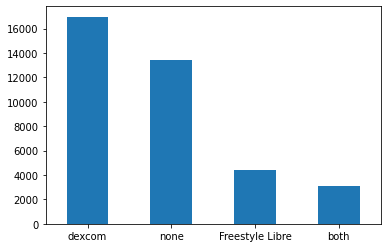

In [ ]:
df_p3["Category"].value_counts().plot(kind = 'bar',rot=0)

### Freestyle Libre Product-related analysis

### a. What are praises & complaints and features of Freestyle Libre?

First, we build the subset of freestyle libre comment in different sentiments.

In [ ]:
FL = df_p3[(df_p3["Category"] == "Freestyle Libre")]
FL_positive = df_p3[(df_p3["Sentiment"] == "Positives") & (df_p3["Category"] == "Freestyle Libre")]["text_clean"]
FL_negative = df_p3[(df_p3["Sentiment"] == "Negatives") & (df_p3["Category"] == "Freestyle Libre")]["text_clean"]
FL_neutral = df_p3[(df_p3["Sentiment"] == "Neutrals") & (df_p3["Category"] == "Freestyle Libre")]["text_clean"]
FL_mix = df_p3[(df_p3["Sentiment"] == "Mixed") & (df_p3["Category"] == "Freestyle Libre")]["text_clean"]

Let's check the number of texts in different setiments. 

In [ ]:
print("total number of category = Freestyle Libre: {}".format(len(FL)))
print("# of rows in category = Freestyle Libre, sentiment = positive: {}".format(len(FL_positive)))
print("# of rows in category = Freestyle Libre, sentiment = negative: {}".format(len(FL_negative)))
print("# of rows in category = Freestyle Libre, sentiment = neutrals: {}".format(len(FL_neutral)))
print("# of rows in category = Freestyle Libre, sentiment = mixed: {}".format(len(FL_mix)))

total number of category = Freestyle Libre: 4401
# of rows in category = Freestyle Libre, sentiment = positive: 1381
# of rows in category = Freestyle Libre, sentiment = negative: 223
# of rows in category = Freestyle Libre, sentiment = neutrals: 2714
# of rows in category = Freestyle Libre, sentiment = mixed: 83


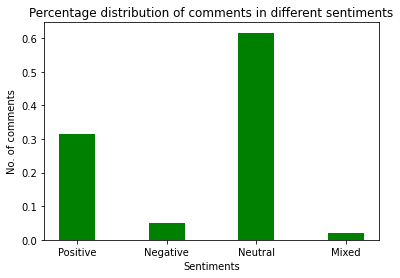

In [ ]:
sentiment_dis = {'Positive': len(FL_positive)/len(FL), 'Negative': len(FL_negative)/len(FL), 
        'Neutral': len(FL_neutral)/len(FL),'Mixed': len(FL_mix)/len(FL)}
#sentiment_dis_df = pd.DataFrame.from_dict(sentiment_dis)

sentiments = list(sentiment_dis.keys())
numbers = list(sentiment_dis.values())
  
#fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(sentiments, numbers, color ='green',
        width = 0.4)
 
plt.xlabel("Sentiments")
plt.ylabel("No. of comments")
plt.title("Percentage distribution of comments in different sentiments")
plt.show()

Then, we can use the sentiments from vadar and textblob to do a visualize to do a comparison.

In [ ]:
tmp1 = FL[['TextBlob', 'vader']]

trace1 = go.Histogram(x=tmp1['TextBlob'], opacity=0.5, name='TextBlob')
trace2 = go.Histogram(x=tmp1['vader'], opacity=0.5, name='Vader')

tmp2 = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Histogram of Two Sentiment Analysis tools', xaxis=dict(title='Value'), yaxis=dict(title='Count'))
fig = go.Figure(data=tmp2, layout=layout)
fig.show()

The distribution of Textblob is very similar to the original sentiment column from the dataset that the neutral comments are the major component. However, the distribution of Vader is quite different. Vader categorizes more comments as positive and has much lower amount of neutral comments. In the later steps, we will continue to use the sentiment column from the data to do the analysis for praises, complaints and features.

### Praises Analysis

We will focus on the comment with a positive sentiment label for praise analysis.  Our first approach is to tag all the words in the different speech of words (noun, verb, adjective).

In [ ]:
adjs = []
nouns = []
verbs = []

for i in FL_positive:
    for token in nlp(i):
        if token.pos_ == 'ADJ':
            adjs.append(token.text)
        elif token.pos_ == 'NOUN':
            nouns.append(token.text)
        elif token.pos_ == 'VERB':
            verbs.append(token.text)

adjs_count = Counter(adjs)
nouns_count = Counter(nouns)
verbs_count = Counter(verbs) 

Visualing the noun.

Word cloud for nouns


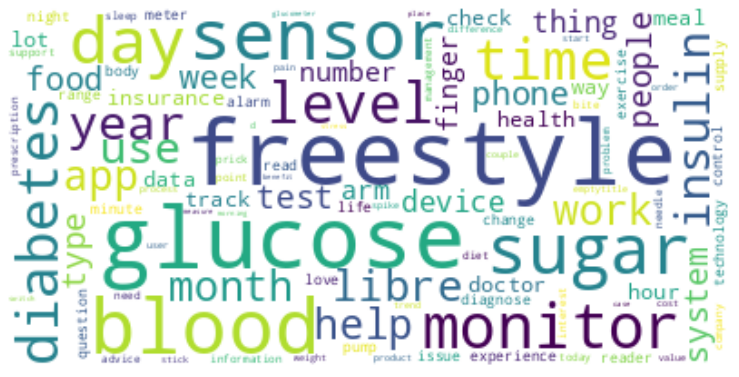

In [ ]:
print("Word cloud for nouns")
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(nouns_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

Word cloud for adjectives


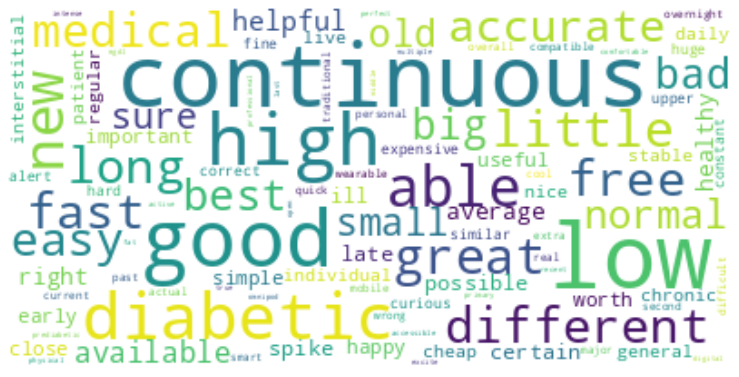

In [ ]:
print("Word cloud for adjectives")
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(adjs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

Word cloud for verbs


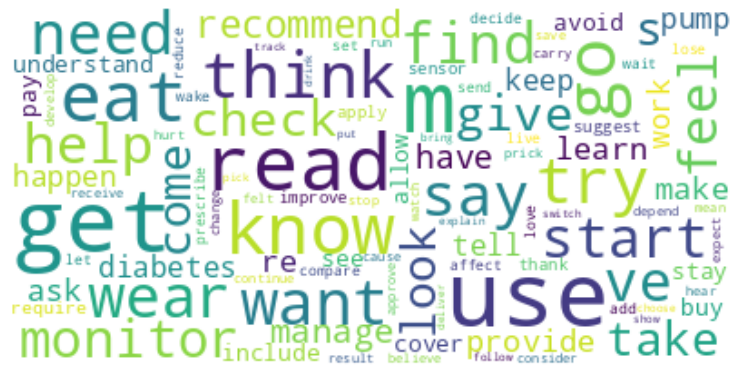

In [ ]:
print("Word cloud for verbs")
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(verbs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

It isn't easy to find insight by analyzing 1-gram text. We will try different n_gram analyses in the following part.

* N-gram = 3 analysis

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_positive)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('continuous glucose monitor', 278),
 ('use freestyle libre', 252),
 ('freestyle libre sensor', 165),
 ('libre 14 day', 65),
 ('freestyle libre 14', 64),
 ('wear freestyle libre', 63),
 ('freestyle libre cgm', 58),
 ('blood sugar level', 56),
 ('ive freestyle libre', 50),
 ('glucose monitor cgm', 48),
 ('im freestyle libre', 42),
 ('freestyle libre app', 36),
 ('libre continuous glucose', 35),
 ('freestyle libre continuous', 32),
 ('check blood sugar', 31),
 ('cgm freestyle libre', 29),
 ('low blood sugar', 28),
 ('blood glucose monitor', 27),
 ('flash glucose monitor', 27),
 ('freestyle libre help', 27),
 ('buy freestyle libre', 25),
 ('14 day sensor', 24),
 ('abbott freestyle libre', 24),
 ('try freestyle libre', 24),
 ('blood glucose level', 23)]

Based on the above result, we can identify some Freestyle Libre features:  
1. continuous glucose monitor
2. wear freestyle libre
3. 14-day sensor 

Since we are analyzing the CGM Freestyle Libre product, it is expected that we can see lots of disease-related and product-related words (high frequency). These words may cover the customer's insights. Therefore, we will remove these words.

In [ ]:
# Freestyle Libre-related stop words
FL_stop = ['cgm', 'diabetes','blood','glucose','sugar','continuous','freestyle', 'libre', 'monitoring','pump','1','2','14','insulin', 'tslim']

* N-gram = 3 analysis - remove disease-related and product-related stop words

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_positive)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('medical supply brooklyn', 22),
 ('flash monitor system', 18),
 ('credit natasha lomastechcrunch', 12),
 ('image credit natasha', 12),
 ('app compatible certain', 10),
 ('certain mobile device', 10),
 ('compatible certain mobile', 10),
 ('device operate system', 10),
 ('mobile device operate', 10),
 ('require registration libreview', 10),
 ('disease cardiovascular disease', 8),
 ('finger prick test', 8),
 ('inflammation oxidative stress', 8),
 ('measure interstitial fluid', 8),
 ('startup productizing technology', 8),
 ('app require registration', 7),
 ('compatibility app use', 7),
 ('data file abbott', 7),
 ('device compatibility app', 7),
 ('file abbott care', 7),
 ('information device compatibility', 7),
 ('interstitial fluid level', 7),
 ('operate system check', 7),
 ('read phone minute', 7),
 ('alarm level set', 6)]

After removing the disease-related and product-related words, we can identify more information in Freestyle Libre's positive comments:  
1. Features  
- flash monitor system
- app compatible
- mobile device operate
- app requires registration
- read phone minute
- alarm level set

2. positive effect of KOL  
- We can see the name Natasha in the comment. Natasha is using Freestyle Libre to manage her diabetes. 
ref: https://www.tatlerasia.com/the-scene/people-parties/joanna-and-natasha-hotung-youth-diabetes-action

3. Disease management (further analysis needed)
- some disease terms were mentioned in the text. It may link to disease management. However, more analysis is needed.

We will try n_gram = 5 and 8 to see if we can get more insights.


* N-gram = 5 analysis - remove disease-related and product-related stop words

In [ ]:
# n_gram = 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_positive)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('app compatible certain mobile device', 10),
 ('certain mobile device operate system', 10),
 ('compatible certain mobile device operate', 10),
 ('information device compatibility app use', 7),
 ('mobile device operate system check', 7),
 ('base comparison list price portfolio', 6),
 ('comparison list price portfolio versus', 6),
 ('librelinkup app compatible certain mobile', 6),
 ('list price portfolio versus competitor', 6),
 ('price portfolio versus competitor system', 6),
 ('action especially im comfortable guy', 5),
 ('aita check desk coworker severe', 5),
 ('alarm turn sensor 20 foot', 5),
 ('amaze post dont vuori romper', 5),
 ('application guy action especially im', 5),
 ('application process nutrisense use note', 5),
 ('big needle phobe easy painless', 5),
 ('case wonder tip get nutrisense', 5),
 ('check desk coworker severe phobia', 5),
 ('comfortable guy im big needle', 5),
 ('doctor work im share experience', 5),
 ('dont vuori romper life change', 5),
 ('easy painless inse

In [ ]:
# n_gram = 8
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (8, 8)) 
tf = tf_vectorizer.fit_transform(FL_positive)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('app compatible certain mobile device operate system check', 7),
 ('base comparison list price portfolio versus competitor system', 6),
 ('librelinkup app compatible certain mobile device operate system', 6),
 ('action especially im comfortable guy im big needle', 5),
 ('amaze post dont vuori romper life change get', 5),
 ('application guy action especially im comfortable guy im', 5),
 ('application process nutrisense use note im doctor work', 5),
 ('big needle phobe easy painless insert here video', 5),
 ('comfortable guy im big needle phobe easy painless', 5),
 ('doctor work im share experience case wonder tip', 5),
 ('easy painless insert here video application process nutrisense', 5),
 ('especially im comfortable guy im big needle phobe', 5),
 ('guy action especially im comfortable guy im big', 5),
 ('guy im big needle phobe easy painless insert', 5),
 ('happy amaze post dont vuori romper life change', 5),
 ('here video application process nutrisense use note im', 5),
 ('im big n

New information is retrieved:
- easy painless insert here video application process nutrisense
- something related to price (price portfolio versus competitor system)
- Comfortable

We identify several features and praises of Freestyle Libre. However, we didn't see much of how customers feel about this product. We will try topic modeling to reveal more information. 

In [ ]:
# import topic modeling package
from sklearn.decomposition import LatentDirichletAllocation

* Topic modeling for Freestyle Libre positive comment - n_gram = 3, topic = 5

In [ ]:
# n_gram = 3, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_positive)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
medical supply brooklyn : 0.012005373554670302
diabetic test supply : 0.0033528523978439357
traditional diabetic test : 0.0033528523978439357
time stress money : 0.0033528467169672664
save time stress : 0.0033528467169672664
application guy action : 0.002812068941762995
experience case wonder : 0.002812068941762995
life change get : 0.002812068941762995
especially im comfortable : 0.002812068941762995
take quick video : 0.002812068941762995
quick video application : 0.002812068941762995
dont vuori romper : 0.002812068941762995
comfortable guy im : 0.002812068941762995
process nutrisense use : 0.002812068941762995
doctor work im : 0.002812068941762995
post dont vuori : 0.002812068941762995
wonder tip get : 0.002812068941762995
action especially im : 0.002812068941762995
work im share : 0.002812068941762995
amaze post dont : 0.002812068941762995
application process nutrisense : 0.0028120689417629

Following insights were captured from the topic modeling result:
- input data: Freestyle Libre, Positive
- N_gram = 3, topic = 5

* Topic 0 - easy to insert, comfortable, life changer
1.	Easy to insert
2.	Comfortable
3.	Life change

* Topic 1 - compatible with app, user can set alarm level
1.	App compatible
2.	Flash monitor system
3.	Alarm level set

* Topic 2 - user can read the data by phone, non-invasive device, affordable  
ref: https://abbott.mediaroom.com/2018-07-27-Abbotts-FreeStyle-R-Libre-14-Day-Flash-Glucose-Monitoring-System-Now-Approved-in-U-S
1.	Read phone minute
2.	Mention way affordable
3.	Changer consider noninvasive

* Topic 3 - good for health management
1.	Long term health
2.	Help manage condition 
-	Inflammation oxidative stress, disease cardiovascular disease, etc
3.	Pay attention metabolic

* Topic 4 - accurate, life lot easy
1.	Close loop system
2.	Fairly accurate compare
3.	Read phone app
4.	Life lot easy
5.	Help monitor value
6.	Monitor system help


In the following part, we will try n_gram = 5 to see if we can reveal more information from user's comments.


In [ ]:
# n_gram = 5, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_positive)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
check desk coworker severe phobia : 0.0056243241291320115
aita check desk coworker severe : 0.0056243241291320115
abbott maker found partner type : 0.004542732842446258
event sleep understand low occasion : 0.0045416087791884515
number provide announcement ceo people : 0.0034611500656864655
traditional diabetic test supply novel : 0.0034611500656864655
traditional diabetic test supply painless : 0.0034611500656864655
possible feature monitor machine provide : 0.0034611500656864655
decide intimate member public traditional : 0.0034611500656864655
streamline order process product product : 0.0034611500656864655
hospital diabetic patient active work : 0.0034611500656864655
announcement ceo people find reason : 0.0034611500656864655
hospital save people pain streamline : 0.0034611500656864655
hospital say owner company get : 0.0034611500656864655
battle irregular level advantage sensor : 0.00346115

Following insights were captured from the topic modeling result:
- input data: Freestyle Libre, Positive
- N_gram = 5, topic = 5

* Topic 0
1.	Traditional diabetic test supply novel
2.	Traditional diabetic test supply painless
3.	Time spend visit hospital save

* Topic 1
1.	Painless – needle phobe
2.	Needel phobe easy painless insert

* Topic 2
1.	Long term health metabolic tracker
2.	Mass access realtime metabolic data

* Topic 3. 
  
  No specific insight 

* Topic 4
1.	information device compatibility app use
2.	comparison list price portfolio versus
3.	notification receive alarm turn sensor
4.	seamless digital experience simplify management

Although this part aims to analyze the praise, we also identify some features in the result. Following is a summary of the elements and praises.

### Summary of features
1. flash monitor system
2. app compatible
3. mobile device operate
4. app require registration
5. read phone minute
6. alarm level set (https://diabeticoutlet.com/the-libre-14-day-reader-has-been-discontinued-what-you-need-to-know/)
(Libre 2 is avaliable on June 15, 2020)

### Summary of praises
1.	compatible with app, easy access to data
2.	good for health management
3.	painless when insert the sensor
4.	save time going to the hospital
5. affordable (https://www.healthline.com/diabetesmine/when-you-cant-afford-a-cgm#Abbott-FreeStyle-Libre-2-)
6. Comfortable

### Complaints analysis
Following the same method as analyzing positive comment to analyze negative comment. 

In [ ]:
# n_gram = 3
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_negative)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('medical supply bronx', 7),
 ('diabetic dog get', 4),
 ('family member diabetic', 4),
 ('free knee brace', 4),
 ('low finger prick', 4),
 ('member diabetic dog', 4),
 ('finger prick test', 3),
 ('thing know buy', 3),
 ('wear knee brace', 3),
 ('10 year old', 2),
 ('770g giant step', 2),
 ('app slow unresponsive', 2),
 ('backwards technologically 10', 2),
 ('bad non recyclable', 2),
 ('brace fit condition', 2),
 ('brace neoprene sleeve', 2),
 ('care service provider', 2),
 ('change feel bad', 2),
 ('cmp patella control', 2),
 ('come try stay', 2),
 ('device attach body', 2),
 ('diabetic absolutely pathetic', 2),
 ('difference read check', 2),
 ('drive stroll extend', 2),
 ('el struggle heatwave', 2)]

Based on the 3_gram analysis, we can observe following complaints in Freestyle Libre:
1. app slow unresponsive
2. backwards technology
3. bad on recyclable
4. device attach body
5. change feel bad

Let's see if we can get more information by trying 5_gram.

In [ ]:
# n_gram = 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_negative)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('family member diabetic dog get', 4),
 ('10 year old point think', 2),
 ('770g giant step backwards technologically', 2),
 ('backwards technologically 10 year old', 2),
 ('bad non recyclable trash come', 2),
 ('change feel bad non recyclable', 2),
 ('drive stroll extend contraindication knee', 2),
 ('feel bad non recyclable trash', 2),
 ('giant step backwards technologically 10', 2),
 ('health care service provider physical', 2),
 ('infusion change feel bad non', 2),
 ('joke need perspective diabetic absolutely', 2),
 ('medtronic 770g giant step backwards', 2),
 ('morning huge difference read check', 2),
 ('need perspective diabetic absolutely pathetic', 2),
 ('new medtronic 770g giant step', 2),
 ('new sensor morning huge difference', 2),
 ('non recyclable trash come try', 2),
 ('old point think joke need', 2),
 ('point think joke need perspective', 2),
 ('recyclable trash come try stay', 2),
 ('sensor morning huge difference read', 2),
 ('shiny new medtronic 770g giant', 2),
 ('sit

Summary of the 5_gram analysis result:
1. Not able to recycling is a big issue
2. huge read difference in the morning --- new complaint
3. backwards technologically 10 year old

Topic modeling is also used to reveal more insights.

In [ ]:
# Topic modeling
# n_gram = 3, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_negative)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
finger prick test : 0.04951628815041799
sensor morning huge : 0.034042933964336435
new sensor morning : 0.034042933964336435
morning huge difference : 0.034042933964336435
huge difference read : 0.034042933964336435
difference read check : 0.034042933964336435
vent thread free : 0.03404248154263007
weekly rdiabetes vent : 0.03404248154263007
rdiabetes vent thread : 0.03404248154263007
el struggle heatwave : 0.034040769415921164
extend contraindication knee : 0.033999236422830356
selection instance knee : 0.033999236385398784
stroll extend contraindication : 0.033999236297991946
save time stress : 0.03399923623683234
fit condition useful : 0.03399923621446081
cmp patella control : 0.03399923605679373
brace neoprene sleeve : 0.03399923599725954
patella control support : 0.03399923596626803
sit drive stroll : 0.033999235916578045
time stress money : 0.033999235902539005
drive stroll extend : 0.033

Summary for the complaint analysis:
n_gram = 3, topic = 5

* Topic 1
1.	morning huge difference
2.	stroll extend contraindication?

* Topic 2
1.	step backwards technologically
2.	have issue sensor
3.	device attach body

* Topic 3
1.	slow unresponsive sudden

* Topic 4. 

  no specific insight

* Topic 5
1.	recyclable trash come

Let's try n_gram = 5, topic = 5

In [ ]:
# Topic modeling
# n_gram = 5, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_negative)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
family member diabetic dog get : 0.2530024096942862
new sensor morning huge difference : 0.13252770780853035
morning huge difference read check : 0.13252770780853035
sensor morning huge difference read : 0.13252770780853035
health care service provider physical : 0.012050763211206995
sit drive stroll extend contraindication : 0.01204971160468521
drive stroll extend contraindication knee : 0.01204971160468521
weekly rdiabetes vent thread free : 0.012049484248420894
non recyclable trash come try : 0.012048675737780864
infusion change feel bad non : 0.012048675737780864
feel bad non recyclable trash : 0.012048675737780864
change feel bad non recyclable : 0.012048675737780864
bad non recyclable trash come : 0.012048675737780864
trash infusion change feel bad : 0.012048675737780864
trash come try stay alive : 0.012048675737780864
recyclable trash come try stay : 0.012048675737780864
think shiny new 

No new complaint is revealed in the n_gram = 5, topic = 5 analysis. Below is the summary of the complaints in this part of the analysis. 

### Feature Analysis

We have identified some features from the praises analysis. However, users may discuss the feature in the nutral and mixed comments. Therefore, we will also analysis the neutral and mixed comment for feature analysis.

In [ ]:
# Neutral comments
# n_gram = 3
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('medical supply brooklyn', 53),
 ('medical supply bronx', 28),
 ('knee dental brace', 15),
 ('belt come mind', 12),
 ('close loop system', 12),
 ('free knee brace', 11),
 ('im type diabetic', 10),
 ('injury persistent pain', 10),
 ('diabetesdiet diabeticfriendly diabetesticmuscleandfitness', 9),
 ('diabetesticmuscleandfitness friend family', 9),
 ('diabeticfood diabeticlife novamix', 9),
 ('diabeticfriendly diabetesticmuscleandfitness friend', 9),
 ('diabeticlife novamix novarapid', 9),
 ('diabeticmeals diabeticrecipes diabetesdiet', 9),
 ('diabeticrecipes diabetesdiet diabeticfriendly', 9),
 ('finger prick test', 9),
 ('freestylelibre iamdiabetic diabeticfood', 9),
 ('friend family god', 9),
 ('guide medical supply', 9),
 ('iamdiabetic diabeticfood diabeticlife', 9),
 ('knee brace knee', 9),
 ('low finger prick', 9),
 ('novamix novarapid diabeticmeals', 9),
 ('novarapid diabeticmeals diabeticrecipes', 9),
 ('rdiabetes vent thread', 9)]

In [ ]:
# Neutral comments
# n_gram = 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

word = list(tf_vectorizer.get_feature_names())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

There is no new features identified. However, we can see one interesting 5_gram word come out - apple watch likely gain pressure. This is the praise for the Freestyle Libre.

In [ ]:
# Topic modeling
# n_gram = 3, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
low finger prick : 0.004921810197871378
rdiabetes vent thread : 0.004921684933571827
weekly rdiabetes vent : 0.004921684933571827
pressure alcohol monitor : 0.004386841543153568
likely gain pressure : 0.004386841543153568
apple watch likely : 0.004386841543153568
watch likely gain : 0.004386841543153568
gain pressure alcohol : 0.004386841543153568
low carb diet : 0.003858848869262801
daily chat post : 0.003325640958077398
significantly low finger : 0.003316877499497913
prick detail post : 0.003316877499497913
finger prick detail : 0.003316877499497913
read significantly low : 0.003316877499497913
diabetessupport typeonefitness typeoneparents : 0.002781903458177972
insulinedependent bloodsugar thattpye1life : 0.002781903458177972
insuline4all freestylelibre abbottfreestylelibre : 0.002781903458177972
t1dlookslikeme insulinedependent bloodsugar : 0.002781903458177972
thattpye1life thattypeonelife

In [ ]:
# Topic modeling
# n_gram = 5, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
likely gain pressure alcohol monitor : 0.01115673492011329
watch likely gain pressure alcohol : 0.01115673492011329
apple watch likely gain pressure : 0.01115673492011329
family member diabetic dog get : 0.009796038220332665
probably need stop test xd : 0.005714287848104693
annoy struggle a1c 65 think : 0.004353817775226797
a1c 65 think find reason : 0.004353817775226797
struggle a1c 65 think find : 0.004353817775226797
decide change location wish luck : 0.00435379243188246
day decide change location wish : 0.00435379243188246
look monitor take frequent read : 0.004353702105195324
ill problem depend sensor em : 0.002993278570932984
optimal way carry vial dont : 0.002993278570932984
pack vial hard find puerto : 0.002993278570932984
ask welcome noob wanna inform : 0.002993278570932984
aunt able help case low : 0.002993278570932984
ill stay airbnb wont money : 0.002993278570932984
warm know frio p

No new information retrieved from the neutral comment analysis. 
In the following part, we will analysis the mixed sentiment comments.

In [ ]:
# Mixed sentiments comments
# n_gram = 3
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_mix)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('check level phone', 3),
 ('able input easy', 2),
 ('accurate watch amaze', 2),
 ('actually matter there', 2),
 ('adjust dietlifestyleactivities support', 2),
 ('alert lowhigh level', 2),
 ('allow multiple entry', 2),
 ('amaze cant use', 2),
 ('announce smartwatch noninvasive', 2),
 ('app come call', 2),
 ('app display data', 2),
 ('app doctor prescribe', 2),
 ('app intend design', 2),
 ('app nutrisense app', 2),
 ('app opinion youre', 2),
 ('app terrible term', 2),
 ('apply he shift', 2),
 ('apps come completely', 2),
 ('arm patch dont', 2),
 ('battery quickly accurate', 2),
 ('battery use kill', 2),
 ('benefit ive write', 2),
 ('biweekly arm patch', 2),
 ('body need want', 2),
 ('body react differently', 2)]

In [ ]:
# Mixed sentiments comments
# n_gram = 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_mix)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('able input easy trend metabolic', 2),
 ('accurate watch amaze cant use', 2),
 ('actually matter there technology greatly', 2),
 ('adjust dietlifestyleactivities support metabolic health', 2),
 ('alert lowhigh level click expand', 2),
 ('allow multiple entry type track', 2),
 ('amaze cant use government support', 2),
 ('app come call librelink librelink', 2),
 ('app display data clearly allow', 2),
 ('app doctor prescribe likely receive', 2),
 ('app intend design diabetic doctor', 2),
 ('app nutrisense app opinion youre', 2),
 ('app opinion youre unsure want', 2),
 ('app terrible term battery use', 2),
 ('apply he shift take thing', 2),
 ('apps come completely rise occasion', 2),
 ('arm patch dont feel prick', 2),
 ('battery quickly accurate watch amaze', 2),
 ('battery use kill battery quickly', 2),
 ('benefit ive write monitor youre', 2),
 ('biweekly arm patch dont feel', 2),
 ('body need want app display', 2),
 ('body react differently carbohydrate mechanism', 2),
 ('boki95 oneplu

In [ ]:
# Mixed sentiments comments
# n_gram = 8
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (8, 8)) 
tf = tf_vectorizer.fit_transform(FL_mix)

word = list(tf_vectorizer.get_feature_names_out())
count = tf.sum(axis=0).A1
word_series = Counter(dict(zip(word, count)))
word_series.most_common(25)

[('able input easy trend metabolic fluctuation spot opportunity', 2),
 ('accurate watch amaze cant use government support sensor', 2),
 ('actually matter there technology greatly improve patient qualityoflife', 2),
 ('adjust dietlifestyleactivities support metabolic health librelink standard app',
  2),
 ('alert lowhigh level click expand app terrible term', 2),
 ('allow multiple entry type track want youre able', 2),
 ('amaze cant use government support sensor quantum announce', 2),
 ('app come call librelink librelink app intend design', 2),
 ('app display data clearly allow multiple entry type', 2),
 ('app doctor prescribe likely receive expect use app', 2),
 ('app intend design diabetic doctor want use check', 2),
 ('app nutrisense app opinion youre unsure want wear', 2),
 ('app opinion youre unsure want wear benefit ive', 2),
 ('app terrible term battery use kill battery quickly', 2),
 ('apply he shift take thing help check level', 2),
 ('apps come completely rise occasion look us

When we increase the number of n_gram (5 & 8), we obtained more information:
1. app display data clearly allow multiple entry type
2. there seems to be some issue wiht the battery (battery use kill, battery quickly)

In [ ]:
# Topic modeling
# n_gram = 3, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
low finger prick : 0.004921810197871378
rdiabetes vent thread : 0.004921684933571827
weekly rdiabetes vent : 0.004921684933571827
pressure alcohol monitor : 0.004386841543153568
likely gain pressure : 0.004386841543153568
apple watch likely : 0.004386841543153568
watch likely gain : 0.004386841543153568
gain pressure alcohol : 0.004386841543153568
low carb diet : 0.003858848869262801
daily chat post : 0.003325640958077398
significantly low finger : 0.003316877499497913
prick detail post : 0.003316877499497913
finger prick detail : 0.003316877499497913
read significantly low : 0.003316877499497913
diabetessupport typeonefitness typeoneparents : 0.002781903458177972
insulinedependent bloodsugar thattpye1life : 0.002781903458177972
insuline4all freestylelibre abbottfreestylelibre : 0.002781903458177972
t1dlookslikeme insulinedependent bloodsugar : 0.002781903458177972
thattpye1life thattypeonelife

In [ ]:
# Topic modeling
# n_gram = 5, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (5, 5)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
likely gain pressure alcohol monitor : 0.01115673492011329
watch likely gain pressure alcohol : 0.01115673492011329
apple watch likely gain pressure : 0.01115673492011329
family member diabetic dog get : 0.009796038220332665
probably need stop test xd : 0.005714287848104693
annoy struggle a1c 65 think : 0.004353817775226797
a1c 65 think find reason : 0.004353817775226797
struggle a1c 65 think find : 0.004353817775226797
decide change location wish luck : 0.00435379243188246
day decide change location wish : 0.00435379243188246
look monitor take frequent read : 0.004353702105195324
ill problem depend sensor em : 0.002993278570932984
optimal way carry vial dont : 0.002993278570932984
pack vial hard find puerto : 0.002993278570932984
ask welcome noob wanna inform : 0.002993278570932984
aunt able help case low : 0.002993278570932984
ill stay airbnb wont money : 0.002993278570932984
warm know frio p

In [ ]:
# Topic modeling
# n_gram = 8, topic 5
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words= FL_stop, ngram_range = (8, 8)) 
tf = tf_vectorizer.fit_transform(FL_neutral)

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

topic_word_distributions = np.array([row / row.sum() for row in lda.components_]) # probability distribution

num_top_words = 25

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()
      
    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

        
print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 25 words per topic and their probabilities within the topic...

[Topic 0]
t1dawareness type1story t1dstrong t1dlookslikeme insulinedependent bloodsugar thattpye1life thattypeonelife : 0.007260543743482961
type1diabetes t1dwarrior chasingthegreen t1dawareness type1story t1dstrong t1dlookslikeme insulinedependent : 0.007260543743482961
typeonediabetic insuline4all freestylelibre abbottfreestylelibre diabetessucks diabetessupport typeonefitness typeoneparents : 0.007260543743482961
thattypeonelife typeonediabetic insuline4all freestylelibre abbottfreestylelibre diabetessucks diabetessupport typeonefitness : 0.007260543743482961
thattpye1life thattypeonelife typeonediabetic insuline4all freestylelibre abbottfreestylelibre diabetessucks diabetessupport : 0.007260543743482961
t1dwarrior chasingthegreen t1dawareness type1story t1dstrong t1dlookslikeme insulinedependent bloodsugar : 0.007260543743482961
t1dstrong t1dlookslikeme insulinedependent bloodsugar thattpye1life that

There are many tag used in the mix comments. We identify some negative feedcak in the analysis:
1. accuracy is a big issue - user decide to switch back to finger stick
2. sensor fail insertion

## Summary of question a - Freestyle Libre
### * Praises
1.   Fairly accurate
2.   Compatible with app, easy to read the data
3.	Good for health management, including chronic disease monitoring
4. Painless when insert the sensor, even the nidle phobe can use the product
5. Affordable



### * Summary of features
1. Flash monitor system - let patient check their sugar levels without finger pricking
2. Freestyle Libre App - read/record data in user's phone 
3. Alarm level set - alert patient if the glucose level is too high or low
4. Wearable device
5. Continuous gloucoses monitor
6. Compatible with insuline pump (Medtronic)



### * Summary of complaint
1. Inaccurate reading when new sensor is replaced 
2. app slow unresponsive - some user also complainted the app will not
response suddenly
3. Non-recyclable material - the material is not recyclable, user feel bad when chaing the material
4.   Backwards technologydevice - Medtronic 770G - we found people complainted about the compatible insulin pump and had negative feedback to the Freestyle Libre CGM




### Dexcom Product-related analysis

### a. What are praises & complaints and features of Dexcom?

First, we build the subset of dexcom comment in different sentiments.

In [ ]:
dexcom = df_p3[df_p3['Category'] == 'dexcom']
dexcom_pos = dexcom[dexcom['Sentiment'] == 'Positives']['text_clean']
dexcom_neg = dexcom[dexcom['Sentiment'] == 'Negatives']['text_clean']
dexcom_neu = dexcom[dexcom['Sentiment'] == 'Neutrals']['text_clean']
dexcom_mix = dexcom[dexcom['Sentiment'] == 'Mixed']['text_clean']

Using the original sentiment column from dataset to visualize the distribution 

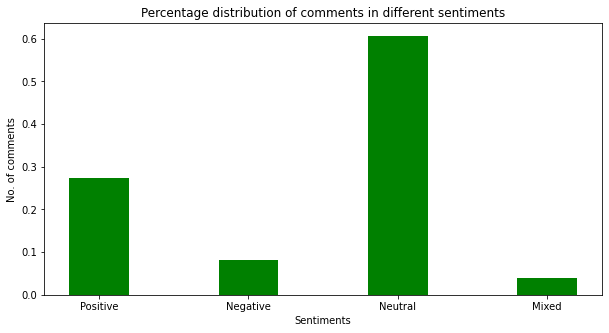

In [ ]:
sentiment_dis2 = {'Positive': len(dexcom_pos)/len(dexcom), 'Negative': len(dexcom_neg)/len(dexcom), 'Neutral': len(dexcom_neu)/len(dexcom),'Mixed': len(dexcom_mix)/len(dexcom)}

sentiments2 = list(sentiment_dis2.keys())
numbers2 = list(sentiment_dis2.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(sentiments2, numbers2, color ='green',
        width = 0.4)
 
plt.xlabel("Sentiments")
plt.ylabel("No. of comments")
plt.title("Percentage distribution of comments in different sentiments")
plt.show()

For Dexcom, the neutral comments are the major component (60%), and the positive comments are more than twice of negative comments. 

Then, we can use the sentiments from vadar and textblob to do a visualize again.

In [ ]:
tmp1 = dexcom[['TextBlob', 'vader']]

trace1 = go.Histogram(x=tmp1['TextBlob'], opacity=0.5, name='TextBlob')
trace2 = go.Histogram(x=tmp1['vader'], opacity=0.5, name='Vader')

tmp2 = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Histogram of Two Sentiment Analysis tools', xaxis=dict(title='Value'), yaxis=dict(title='Count'))

fig = go.Figure(data=tmp2, layout=layout)
fig.show()

The distribution of Textblob is very similar to the original sentiment column from the dataset but the distribution of Vader is quite different. Vader categorizes more comments as positive and negatives and has much lower amount of neutral comments. In the later steps, we will continue to use the sentiment column from the data to do the analysis for praises, complaints and features.

### Praises Analysis

We will focus on the comment with a positive sentiment label for praise analysis. Our first approach is to tag all the words in the different speech of words (noun, verb, adjective).

In [ ]:
adjs = []
nouns = []
verbs = []

for i in dexcom_pos:
    for token in nlp(i):
        if token.pos_ == 'ADJ':
            adjs.append(token.text)
        elif token.pos_ == 'NOUN':
            nouns.append(token.text)
        elif token.pos_ == 'VERB':
            verbs.append(token.text)

adjs_count = Counter(adjs)
nouns_count = Counter(nouns)
verbs_count = Counter(verbs) 

Visualize the noun using word cloud

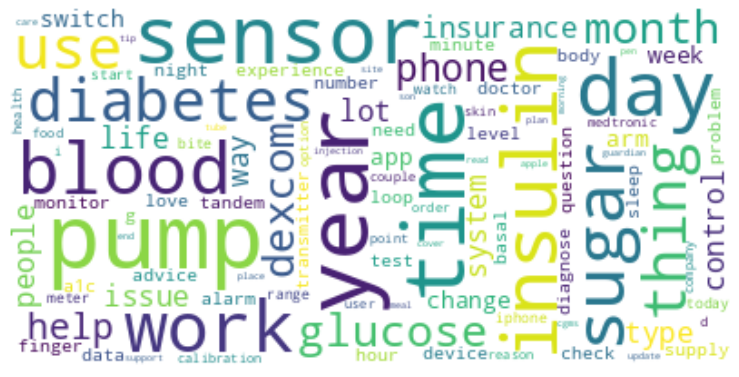

In [ ]:
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(nouns_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

From the word cloud, we can see the most popular nouns are diabetes, sensor, blood, sugar, glucose, insulin, pump, control etc which are expectale since they are the major topics about diabetes continuous glucose monitoring.

Visualize the adjectives by using word cloud

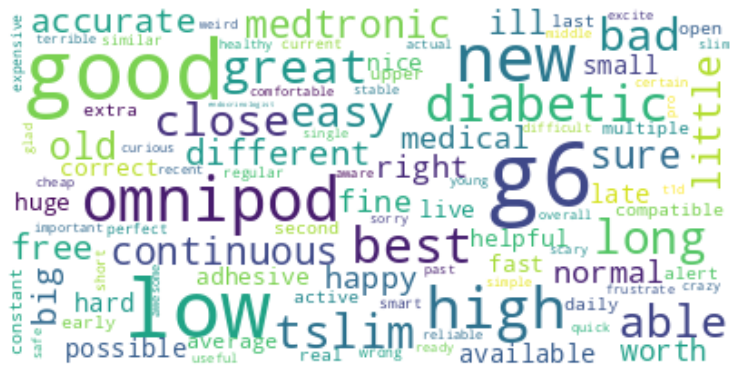

In [ ]:
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(adjs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

From the adjective word count, we can see that the insights are limited because some words are not really adjective such as tslim and g6. And, there is supposed to be positive adjectives but we can see some negative words ssuch as bad, expensive. So maybe the messages try to convey are like not bad and not expensive so we can use n_gram analysis to dig in.

Visulaize the verb using word cloud

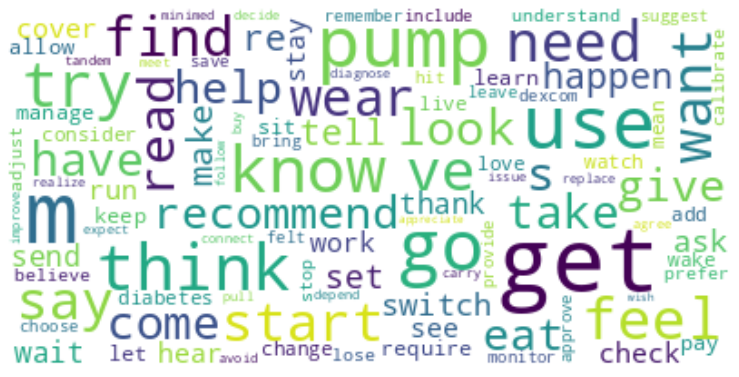

In [ ]:
wc_adj = WordCloud(background_color='white', max_font_size=50, max_words=100, stopwords=STOPWORDS).generate_from_frequencies(verbs_count)
plt.figure(figsize=(13, 9))
plt.imshow(wc_adj, interpolation="bilinear")
plt.axis('off')
plt.show()

Just like the previous two cloud words, we can hardly get useful and insightful information from the visualization. 

### N-Gram analysis

3-gram analysis

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words='english', 
                                ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(dexcom_pos)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('continuous glucose monitor', 237),
 ('use dexcom g6', 208),
 ('dexcom g6 cgm', 79),
 ('dexcom g6 app', 69),
 ('tandem tslim x2', 68),
 ('dexcom g6 sensor', 58),
 ('wear dexcom g6', 52),
 ('low blood sugar', 51),
 ('glucose monitor cgm', 49),
 ('blood sugar level', 48),
 ('check blood sugar', 45),
 ('dexcom g6 omnipod', 44),
 ('tslim x2 dexcom', 44),
 ('im dexcom g6', 42),
 ('ive dexcom g6', 42),
 ('dexcom g6 tandem', 36),
 ('x2 dexcom g6', 35),
 ('use dexcom cgm', 33),
 ('high blood sugar', 31),
 ('g6 continuous glucose', 28),
 ('use omnipod dexcom', 28),
 ('blood glucose level', 27),
 ('cgm continuous glucose', 27),
 ('cgm dexcom g6', 27),
 ('dexcom continuous glucose', 26)]

These top 25 most frequent trigrams tells us that Dexcom has continuous glucose monitor product, there is a model type called g6 and g6 has an app and sensor to check blood sugar level. Also, the tslim x2 has been mentioned alot and we did some research and realized that Tandem tslim x2 is a insulin pummp that can be compatible with Dexcom so that Dexcom works to monitor the blood sugar and the tslim x2 gives insulin based on how bloos sugar varies. However, beyond the features, we want to find the praises so we will make a list to remove those information that are repetitive and already known by us.

In [ ]:
pos_stop_word = ['blood','glucose','sugar','continuous','dexcom','monitoring','x2','g5','g6','g7','insulin',
'tslim','770g','780g','omnipod','670g','cgm','medtronic','diabetic','640g','abbott','senseonics','diabetes',
'rdiabetes','thread','meme','tandem','europe','pump','oc','cry','folk']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=pos_stop_word, 
                                ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(dexcom_pos)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('close loop system', 92),
 ('isnt approve arm', 19),
 ('last 10 day', 16),
 ('multiple daily injection', 16),
 ('durable medical equipment', 15),
 ('apple watch series', 14),
 ('get year ago', 14),
 ('have device attach', 14),
 ('hybrid close loop', 14),
 ('device attach body', 13),
 ('feel have device', 13),
 ('insurance wont cover', 13),
 ('iphone 13 pro', 13),
 ('start new sensor', 13),
 ('switch year ago', 13),
 ('year ago get', 12),
 ('feel like im', 11),
 ('highly recommend get', 11),
 ('make life easy', 11),
 ('update base version', 11),
 ('13 pro mobile', 10),
 ('app update base', 10),
 ('base version update', 10),
 ('build app update', 10),
 ('couple year ago', 10)]

After remove the stop words, we can see some praises towards Dexcom such as 'last 10 day', 'durable medical equipment', 'highly recommend get','make life easy'. However, some don't make sense such as 'feel have device' and 'insurance wont cover' since they are more like complaints versus praises. So we wonder maybe because 3 words don't conclude all the messages that are tried to be sent. Therefore, we will redo the process but using 6-gram analysis

6-gram analysis

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=pos_stop_word, 
                                ngram_range = (6, 6)) 
tf = tf_vectorizer.fit_transform(dexcom_pos)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('build app update base version update', 10),
 ('alarm time leave good hear sensor', 8),
 ('constant sensor end alarm time leave', 8),
 ('end alarm time leave good hear', 8),
 ('sensor end alarm time leave good', 8),
 ('22 year battle finally feel free', 7),
 ('box morning 22 year battle finally', 7),
 ('morning 22 year battle finally feel', 7),
 ('open box morning 22 year battle', 7),
 ('con thing look upgrade time approach', 6),
 ('experience pro con thing look upgrade', 6),
 ('hit year mark wonder experience pro', 6),
 ('mark wonder experience pro con thing', 6),
 ('pro con thing look upgrade time', 6),
 ('wonder experience pro con thing look', 6),
 ('year mark wonder experience pro con', 6),
 ('13 pro mobile phone tell possible', 5),
 ('31 diagnose type dont people have', 5),
 ('buy iphone 13 pro mobile phone', 5),
 ('come user 10 year im excite', 5),
 ('connect transmitter iphone 13 pro mobile', 5),
 ('diagnose type dont people have hard', 5),
 ('dont people have hard time adjust

From the 6-word analysis, we can see more praises including '22 year battle finally feel free', 'dont people have hard time adjust','good continue monitor tire abuse finger'. Some customers are tired of abusing their fingers and Dexcom products let them feel free and the products are not too hard for them to adjust.

### Complaints analysis

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words='english', 
                                ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(dexcom_neg)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('continuous glucose monitor', 27),
 ('dexcom g6 app', 23),
 ('low blood sugar', 18),
 ('dexcom g6 sensor', 16),
 ('dexcom g6 transmitter', 16),
 ('high blood sugar', 14),
 ('build dexcom app', 13),
 ('dont use dexcom', 13),
 ('dexcom app update', 10),
 ('rdiabetes vent thread', 10),
 ('weekly rdiabetes vent', 10),
 ('app update base', 9),
 ('base version update', 9),
 ('oc build dexcom', 9),
 ('update base version', 9),
 ('dexcom g6 cgm', 8),
 ('check blood sugar', 7),
 ('daily diabetes meme', 7),
 ('diabetes meme day', 7),
 ('hybrid close loop', 7),
 ('use dexcom g6', 7),
 ('dexcom g6 tslim', 6),
 ('glucose monitor cgm', 6),
 ('insulin pump dexcom', 6),
 ('pump dexcom g6', 6)]

Just like the positive analysis, we also need to remove some stop words to find insights.

In [ ]:
neg_stop_word = ['blood','glucose','sugar','continuous','dexcom','monitoring','x2','pump','g5','g6','g7','insulin',
'tslim','770g','780g','omnipod','670g','cgm','medtronic','diabetic','640g','abbott','senseonics','diabetes',
'rdiabetes','thread','meme','tandem','monitor','1520','81','146','170','150','160','22','68','78','43','363','98',
'im','ago','40','xdripaaps','dexcoms','year','dr','pepper','day','oc','hour','stock','market','drink']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=neg_stop_word, 
                                ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(dexcom_neg)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('close loop system', 20),
 ('app update base', 9),
 ('base version update', 9),
 ('build app update', 9),
 ('update base version', 9),
 ('hybrid close loop', 7),
 ('start new sensor', 5),
 ('app doesnt work', 4),
 ('durable medical equipment', 4),
 ('hate low warn', 4),
 ('low warn system', 4),
 ('send replacement sensor', 4),
 ('sensor month supply', 4),
 ('test finger prick', 4),
 ('use close loop', 4),
 ('wake middle night', 4),
 ('advice switch dexcomtandem', 3),
 ('app stop work', 3),
 ('apple watch update', 3),
 ('best look replacement', 3),
 ('broadcast feature program', 3),
 ('cant find widget', 3),
 ('cartridge infusion set', 3),
 ('data doesnt look', 3),
 ('decide reimagine look', 3)]

We can see the app version have been mentioned a lot so we can imagine the app may have some issues especially there are 'app doesnt work' and 'app stop work' phrases. In addtion, 'cant find widget' indicates that people may be confused about some features. In order to find more data, we will also apply 6-gram analysis to the negative comments. 

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=neg_stop_word, 
                                ngram_range = (6, 6)) 
tf = tf_vectorizer.fit_transform(dexcom_neg)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(25)

[('build app update base version update', 9),
 ('app update base version update new', 3),
 ('base version update new broadcast feature', 3),
 ('decide reimagine look data doesnt look', 3),
 ('drop half give error minute tell', 3),
 ('error minute tell rise know happen', 3),
 ('give error minute tell rise know', 3),
 ('half give error minute tell rise', 3),
 ('look data doesnt look like page', 3),
 ('reimagine look data doesnt look like', 3),
 ('tell drop half give error minute', 3),
 ('update base version update new broadcast', 3),
 ('update new broadcast feature program app', 3),
 ('version update new broadcast feature program', 3),
 ('a1c think itll bad feel good', 2),
 ('able look watch number date week', 2),
 ('android phone suddenly mobile app connect', 2),
 ('anymore level stable yes point way', 2),
 ('app issue connect sensor bluetooth issue', 2),
 ('apple watch able look watch number', 2),
 ('apple watch good success week load', 2),
 ('approve know look pretty excite data', 2),

From the 6-gram analysis, more complaints are found. People complained about the error readings and the sensor connect issue and bluetooth issue especially for android phones. Also, some complaints are about during the midnight, the product might shut down. 

### Neutrals analysis: like we mentioned before, the neutral comments are about half of the total comments so maybe we can get more insights about features from neutral analysis

In [ ]:
neu_stop_word = ['blood','glucose','sugar','continuous','dexcom','monitoring','x2','pump','g5','g6','g7','insulin',
'tslim','770g','780g','omnipod','670g','cgm','medtronic','diabetic','640g','abbott','senseonics','diabetes',
'rdiabetes','thread','meme','tandem','monitor','1520','81','146','170','150','160','22','68','78','43','363','98',
'im','ago','40','xdripaaps','dexcoms','year','dr','pepper','day','oc','hour','stock','market','drink']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=neu_stop_word, 
                                ngram_range = (3, 3)) 
tf = tf_vectorizer.fit_transform(dexcom_neu)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(50)

[('close loop system', 110),
 ('start new sensor', 36),
 ('app update base', 34),
 ('base version update', 34),
 ('build app update', 34),
 ('update base version', 34),
 ('durable medical equipment', 33),
 ('wake middle night', 20),
 ('low carb diet', 19),
 ('dont feel like', 18),
 ('insurance wont cover', 18),
 ('isnt approve arm', 18),
 ('apple watch series', 17),
 ('get apple watch', 17),
 ('insurance doesnt cover', 17),
 ('use regular fingersticks', 17),
 ('use skin tac', 17),
 ('get new phone', 16),
 ('regular fingersticks anymore', 16),
 ('t1d rule break', 16),
 ('use use regular', 16),
 ('dont feel low', 15),
 ('iphone 13 pro', 15),
 ('apple watch work', 14),
 ('check finger stick', 14),
 ('insert new sensor', 14),
 ('recently diagnose type', 14),
 ('175 month way', 13),
 ('550 175 month', 13),
 ('broadcast feature program', 13),
 ('feature program app', 13),
 ('hybrid close loop', 13),
 ('insurance pay 550', 13),
 ('month way high', 13),
 ('new broadcast feature', 13),
 ('pay 5

We can see people talked about the close loop system and app update version a lot. Also the insurance is a big topic. Based on our research, Dexcom products are covered by Medicare and some private and public insurances but still there are some certain insurances don't cover the cost. 'a1c significantly low' indicates the benefits brought from dexcom. 'keep ask calibrate' tells us that the calibration process is not easy to navigate. 

### Mixed comments analysis

In [ ]:
mix_stop_word = ['blood','glucose','sugar','continuous','dexcom','monitoring','x2','pump','g5','g6','g7','insulin',
'tslim','770g','780g','omnipod','670g','cgm','medtronic','diabetic','640g','abbott','senseonics','diabetes',
'rdiabetes','thread','meme','tandem','monitor','1520','81','146','170','150','160','22','68','78','43','363','98',
'im','ago','40','xdripaaps','dexcoms','year','dr','pepper','day','oc','hour','stock','market','drink']

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words=mix_stop_word, 
                                ngram_range = (6, 6)) 
tf = tf_vectorizer.fit_transform(dexcom_mix)
vocab = list(tf_vectorizer.get_feature_names_out())
counts = tf.sum(axis=0).A1
freq_distribution = Counter(dict(zip(vocab, counts)))

freq_distribution.most_common(50)

[('feedback decide new thank advance feedback', 3),
 ('know lab unveil swap fingersticks rf', 3),
 ('lab unveil swap fingersticks rf sensor', 3),
 ('need feedback decide new thank advance', 3),
 ('36 ive see low date mo', 2),
 ('able time give rash mom find', 2),
 ('able use crash different stroke different', 2),
 ('address issue inaccurate sensor failure warmups', 2),
 ('apple watch likely gain pressure alcohol', 2),
 ('bf33 sex 36 ive see low', 2),
 ('claim g6s unacceptable persistent error state', 2),
 ('close loop usersmedtronic sensor etc need', 2),
 ('coke orange juice he super sweaty', 2),
 ('come solution able use crash different', 2),
 ('confirm claim g6s unacceptable persistent error', 2),
 ('crash different stroke different folk upgrapding', 2),
 ('date mo give coke orange juice', 2),
 ('decide series main issue wasnt work', 2),
 ('diabetebuddies warranty think jump ship tandemdexcom', 2),
 ('different folk upgrapding series big uprade', 2),
 ('different stroke different fol

## Summary of question a - Dexcom
### * Praises
1.	last 10 days, durable medical equipment
2.	make life easy and highly recommend to get
3.  easy for users to use and adjust 
4.  set users free from abusing their fingers 
5.  keep a good control of A1C. 

### * Summary of complaint
1. app connect issue and app UI is not user-friendly that users have hard time to navigate 
2. sensor connecting and bluetooth issue 
3. inaccurate readings - some people metioned about false low readings 
4. products tend to have issue during night - either shutdown or wake users wake
5. users complained that they still feel the system attached 
6. some insurances won't cover the dexcom products. 
7. calibration process and warm-up failure


### * Summary of features
1. closed loop system: Tandem pumps have successfully integrated with Dexcom CGMs so that users can monitor blood glucose values through dexcom and inject insulin through Tandem pumps easily. 
2. Dexcom apps: users can view their glucose trends, time in range, and even share CGM data with family or healthcare provider.
3. CGM data can be downloaded and shared with others
4. Transmitter can last 90 days